In [1]:
import ursse.sync_motion_simulation as sms
import pandas as pd
import os 
import numpy as np
from ursse.path_assistant import PathAssistant, shifts_folder
import matplotlib.pyplot as plt
from matplotlib import cm
from datetime import datetime
import pickle
import valstore as vt
from config_ursse import get_from_config
images_dir = os.path.join(get_from_config("URSSE_sync_motion_note_dir"),
                          "images")
from ursse.utils import normalize, myhist

In [2]:
rf_noise_std_list = 1e-5*np.arange(16)
str_label_list = [f'{x:.1e}' for x in rf_noise_std_list]
spad_tts_list = [0.350, 0.400, 0.450]
spad_tts_dist_list = ['Gamma', 'Gaussian']
tot_n = len(str_label_list) * len(spad_tts_list) * len(spad_tts_dist_list)
with open(os.path.join(shifts_folder, "all_data_sim_cache", "all_results.pkl"), 'rb') as f:
    all_results = pickle.load(f)

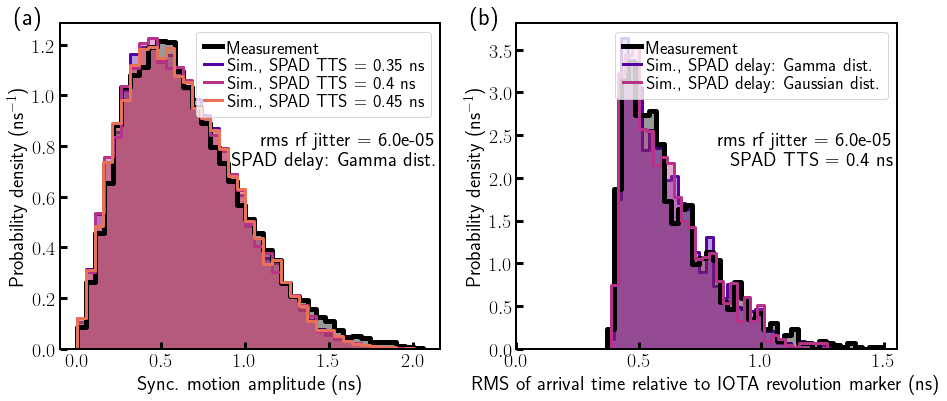

In [5]:
from ursse.path_assistant import get_plot_style_sheet
plt.style.use(get_plot_style_sheet("jinst"))
fit_tts = 0.4
best_rf_label = "6.0e-05"
tts_proj = [r for r in all_results if (r['rf_std_label'] == best_rf_label)\
            and (r['spad_tts_dist'] == 'Gamma')]
fig, axs = plt.subplots(1, 2, figsize=(15,6))
ax0, ax1 = axs

colormap = cm.get_cmap("plasma")
cols = [colormap(i/14) for i in [2,6,9]]
alpha = 0.4
subtitlepos = 0.99, 0.55


for i, res in enumerate([tts_proj[j] for j in [0,1,2]]):
    tts = res['spad_tts']
    data = res['data']
    x = data['amplitude']['bin_centers']
    if i == 0:
        col="black"
        y = normalize(data['amplitude']['aggregated_hists']['meas'])/(x[1]-x[0])
        myhist(ax0, x, y, label="Measurement",
                linewidth=5, color=col, zorder=1)
    y = normalize(data['amplitude']['aggregated_hists']['sim'])/(x[1]-x[0])
    col = cols[i]
    myhist(ax0, x, y, label=f"Sim., SPAD TTS = {tts} ns",
           color=col, zorder=i,
           linewidth=3)
ax0.set_ylabel("Probability density (ns$^{-1}$)")
ax0.set_xlabel("Sync. motion amplitude (ns)")
ax0.text(*subtitlepos,
         f"rms rf jitter = {best_rf_label}"\
         + "\n" + f"SPAD delay: Gamma dist.",
         transform=ax0.transAxes,
         va='bottom', ha='right')
ax0.set_ylim(0, ax0.get_ylim()[1])
ax0.legend()


dist_proj = [r for r in all_results\
                if (r['rf_std_label'] == best_rf_label) and (r['spad_tts'] == fit_tts)]
for i, res in enumerate(dist_proj):
    tts = res['spad_tts']
    data = res['data']
    x = data['rms_length']['bin_centers']
    if i == 0:
        col="black"
        y = normalize(data['rms_length']['aggregated_hists']['meas'])/(x[1]-x[0])
        myhist(ax1, x, y, label="Measurement",
                linewidth=5, color=col, zorder=1)
    y = normalize(data['rms_length']['aggregated_hists']['sim'])/(x[1]-x[0])
    col = cols[i]
    myhist(ax1, x, y, label=f"Sim., SPAD delay: {res['spad_tts_dist']} dist.",
           color=col, zorder=i,
           linewidth=3)
ax1.set_ylabel("Probability density (ns$^{-1}$)")
ax1.set_xlabel("RMS of arrival time relative to IOTA revolution marker (ns)")
ax1.text(*subtitlepos,
         f"rms rf jitter = {best_rf_label}"\
         + "\n" + f"SPAD TTS = {fit_tts} ns",
         transform=ax1.transAxes,
         va='bottom', ha='right')
ax1.set_xlim(0, ax1.get_xlim()[1])
ax1.set_ylim(0, ax1.get_ylim()[1])
ax1.legend()
for ax, lab in zip(axs, ["(a)", "(b)"]):
    ax.text(-0.12, 1.05, lab, transform=ax.transAxes, va='top', ha='left',
           fontsize=24)

fig.savefig(os.path.join(images_dir,
                             "spad_uncertainties.png"),
            dpi=300, bbox_inches='tight')
plt.show()